# ROI
manuell festgelegte ROI soll Punkte verfolgen

- Bild laden
- cut Roi 
- median_filter
- label roi
- check if nur 1 label
- slice werte für object finden 
- Erweiterung festlegen
- neue slice werte mit differncen berechnen 
- check new slides in roi? dann slicen, sonst message und roi neu um Mitte mit Abständen von manuell roi, double check ob object auch in neuer roi liegt 

Test: 
- mehrere ähnliche Bilder mit sich bewegenden Punkt speichern (siehe Camera.ipynb)
- einzeln laden und vorher roi und nachher roi zeigen, etweder mit strichen oder cuts 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import label, find_objects, median_filter, center_of_mass

In [2]:
class Image:
    def __init__(self):
        self.data = self.load_data()
        self.im_shape = self.im_ar.shape

    def load_im (self, nr):
        filename = './test_roi/'+ str(nr) + 'test.npy'
        with open(filename, 'rb') as f:
            ar = np.load(f)
        return ar
    
    def show(self):
        print(self.im_shape)
        plt.imshow(self.im_ar, cmap='gray')
        plt.show()

In [29]:
class ROI:
    def __init__(self,xa,xe,ya,ye,im_ar):
        self.manuel_roi = (slice(ya, ye, None), slice(xa, xe, None))
        self.manuel_roi_y = (self.manuel_roi[0].start, self.manuel_roi[0].stop)
        self.manuel_roi_x = (self.manuel_roi[1].start, self.manuel_roi[1].stop)
        self.diff_y = abs(self.manuel_roi_x[0] - self.manuel_roi_x[1])
        self.diff_x = abs(self.manuel_roi_y[0] - self.manuel_roi_y[1])
        self.roi_ar = im_ar[self.manuel_roi]
        self.roi_med_filt = None
        self.roi_labeled = None
        self.num_label = None
    
    def med_filter(self, size=2):
        self.roi_med_filt = median_filter(self.roi_ar, size=size)

    def labeling(self, schwellwert=70):
        roi_filt = None
        if self.roi_med_filt is not None:
            roi_filt = (self.roi_med_filt > schwellwert)
        else:
            print("labels were given without median filter")
            roi_filt = (self.roi_ar > schwellwert)
        self.roi_labeled, self.num_label = label(roi_filt)
        

    def show(self):
        print(self.manuel_roi_x,self.manuel_roi_y)
        plt.imshow(self.roi_ar, cmap='gray')
        plt.show()
        if self.roi_med_filt is not None:
            plt.imshow(self.roi_med_filt, cmap='gray')
            plt.show()
        if self.roi_labeled is not None:
            if self.num_label: print(self.num_label)
            plt.imshow(self.roi_labeled, cmap='tab10')
            plt.show()




In [79]:
class Licht_object:
    def __init__(self, labeled_roi):
        self.found_slices = find_objects(labeled_roi)[0]
        self.x_e = self.found_slices[1].stop
        self.x_a = self.found_slices[1].start
        self.y_e = self.found_slices[0].stop
        self.y_a = self.found_slices[0].start

        self.new_slice = None
        self.sliced_ar = None
    
    def erweitern(self, erweiterung, a, e, max, min=0):
        a_neu = a - erweiterung
        e_neu = e + erweiterung
        rand = False
        if a_neu < min:
            a_neu = min
            rand = True
            print("Vorsicht Rand")
        if e_neu > max:
            e_neu = max
            rand = True
            print("Vorsicht Rand")
        return a_neu, e_neu, rand
    
    # x und y mit gleichem Wert erweitern 
    def x_y_erweitern_gleich(self, erweiterung, x_a, x_e, y_a, y_e, max_x, max_y):
        y_a_neu, y_e_neu, rand_y = self.erweitern(erweiterung,y_a, y_e, max_y)
        x_a_neu, x_e_neu, rand_x = self.erweitern(erweiterung,x_a, x_e, max_x)
        return (slice(y_a_neu,y_e_neu,None), slice(x_a_neu, x_e_neu, None)), (rand_x or rand_y)

    # x und y mit verschiedenen Werten erweitern 
    def x_y_erweitern_verschieden(self, erweiterung_x, erweiterung_y, x_a, x_e, y_a, y_e, max_x, max_y):
        y_a_neu, y_e_neu, rand_y = self.erweitern(erweiterung_y,y_a, y_e, max_y)
        x_a_neu, x_e_neu, rand_x = self.erweitern(erweiterung_x,x_a, x_e, max_x)
        return (slice(y_a_neu,y_e_neu,None), slice(x_a_neu, x_e_neu, None)), (rand_x or rand_y)

    #verschiedene varianten möglich, hier ein Vorschlag:
    def erweiterung_berechnen_a(self, faktor):
        dif_x = int (abs (self.x_e - self.x_a) * faktor)
        dif_y = int (abs (self.y_e - self.y_a) * faktor)
        return dif_x, dif_y
    
    def slice_ar(self,roi_ar, slice):
        self.sliced_ar = roi_ar[slice]

    def show(self):
        print(self.found_slices)
        print(self.new_slice)
        if self.sliced_ar is not None:
            plt.imshow(self.sliced_ar, cmap='gray')
            plt.show()


Main() Schritt für Schritt testen

(1456, 1936, 1)


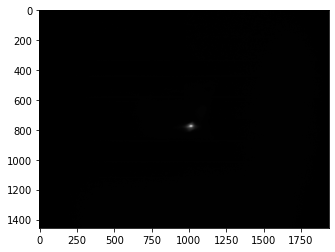

In [5]:
im = Image(1)
im.show()

(800, 1200) (700, 900)


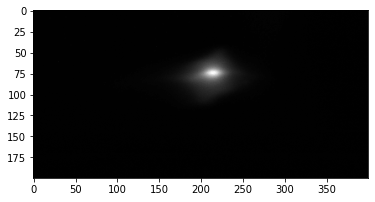

In [30]:
roi = ROI(800,1200,700,900,im.im_ar)
roi.show()

(800, 1200) (700, 900)


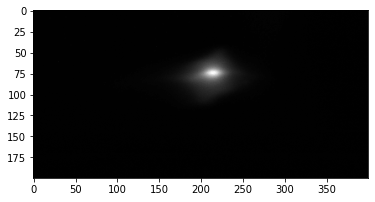

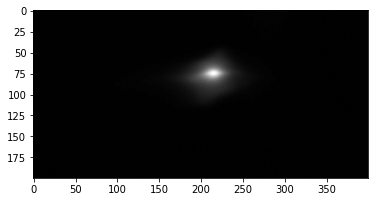

1


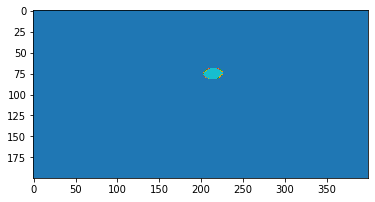

In [31]:
roi.med_filter()
roi.labeling()
roi.show()

In [32]:
if roi.num_label != 1:
    print("hier ist was beim labeln schief gelaufen, vlt zu viele labeled areas")

False
(slice(69, 82, None), slice(203, 227, None), slice(0, 1, None))
(slice(19, 132, None), slice(153, 277, None))


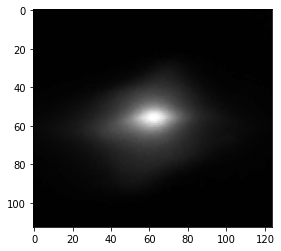

In [81]:
#Basic Erweiterung
ob = Licht_object(roi.roi_labeled)
ob.new_slice, rand = ob.x_y_erweitern_gleich(50, ob.x_a, ob.x_e, ob.y_a, ob.y_e, roi.manuel_roi_x[1], roi.manuel_roi_y[1])
ob.slice_ar(roi.roi_med_filt, ob.new_slice)
ob.show()

(slice(69, 82, None), slice(203, 227, None), slice(0, 1, None))
(slice(50, 101, None), slice(167, 263, None))


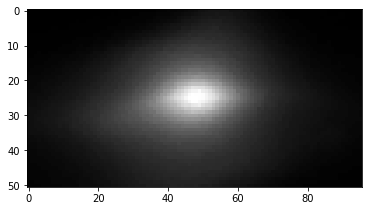

In [82]:
#mit Erweiterungsberechnung
erw_x, erw_y = ob.erweiterung_berechnen_a(faktor=1.5)
ob.new_slice, rand = ob.x_y_erweitern_verschieden(erw_x,erw_y, ob.x_a, ob.x_e, ob.y_a, ob.y_e, roi.manuel_roi_x[1], roi.manuel_roi_y[1])
ob.slice_ar(roi.roi_med_filt,ob.new_slice)
ob.show()

In [83]:
#mit Rand 
ob.new_slice, rand = ob.x_y_erweitern_verschieden(100,300, ob.x_a, ob.x_e, ob.y_a, ob.y_e, roi.manuel_roi_x[1], roi.manuel_roi_y[1])
if rand:
    print("Rand erreicht")
    m_x = (ob.x_e-ob.x_a) //2 + ob.x_a
    m_y = (ob.y_e-ob.y_a) //2 + ob.y_a
    roi.new_roi(m_x,m_y)




Vorsicht Rand
Rand erreicht
